# Convolutional Neural Network
Your programming part of this task includes:
1. Setup the network layer with 3 conv layers, 1 relu layer and 1 softmax layer with a GradientDescentOptimizer.
2. Change the optimizer to the AdamOptimizer.
3. Add a learning decay to the network.
4. Add regularization through dropout.

As a note - for programming subtask 1, all the changes you need to make are within variable declaration/initialization and model setup and as an example you have listing 5.

### Questions
1. Define the output structure of the convolutional layers based on the given stride.
2. For each of the programming subtasks 2-4 point out the changes that happen to the accuracy and error and explain why your modifications caused those changes.


### Answers
1. In the first stride (1,1,1,1) we leave the dimensions as is. In the second and third stride (1,2,2,1) we reduce the pictures by half in each step from 28x28 to 14x14 and finally to 7x7. Thus, the output structure is 7 * 7 * 12, where 12 represents the output channels of the third convolutional layer.
2. The plain convolutional NN with gradient descent has a accuracy of around 10% (random guessing) and a loss between 800 and 2400. This is most likely caused by a poor choice of learning rate at 0.5 (the value which was previously used), which does not converge. Also, the solution might be unstable. The plain NN with Adam optimizer has a best accuarcy of 98.9% and a loss between 5 and 10. Here, the learning rate is much better fitted to the optimizer. In comparison to the previous task we see that the convolutional layers reduce the boucing of parameters as the loss functions seems to be more stable. The convolutional NN with Adam optimizer and learning rate dacy has a best accuarcy of 98.7% and a loss between 6 and 11. This actually decreases our accuarcy a bit and also increases the loss rate, so we achieve exactly the opposite of what we want to reach with learning rate decay. Hence, the learning rate decay is not optimal in this case and we should tune it to increase accuracy and decrease the loss. The convolutional NN with Adam optimizer, learning rate decay and dropout has a best accuracy of 99% and a loss between 4 and 9. Here the dropout method in combination with learning rate decay helps us reducing overfitting to our training data, but as mentioned previously we might want to improve further on our learning rate function.

In [7]:
# all tensorflow api is accessible through this
import tensorflow as tf        
# to visualize the resutls
import matplotlib.pyplot as plt
import math
# 70k mnist dataset that comes with the tensorflow container
from tensorflow.examples.tutorials.mnist import input_data      

tf.set_random_seed(0)                                           

# load data, 60K trainset and 10K testset
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=False, validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz



## Plain Conv NN

In [8]:
# 1. Define Variables and Placeholders
#the first dimension (None) will index the images in the mini-batch
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
Y_ = tf.placeholder(tf.float32, [None, 10])

# Conv layers
W1 = tf.Variable(tf.truncated_normal([5, 5, 1, 4], stddev=0.1))
B1 = tf.Variable(tf.ones([4])/10)
W2 = tf.Variable(tf.truncated_normal([5, 5, 4, 8], stddev=0.1))
B2 = tf.Variable(tf.ones([8])/10)
W3 = tf.Variable(tf.truncated_normal([4, 4, 8, 12], stddev=0.1))
B3 = tf.Variable(tf.ones([12])/10)

# Densely connected layer
W4 = tf.Variable(tf.truncated_normal([7 * 7 * 12, 200], stddev=0.1))
B4 = tf.Variable(tf.ones([200])/10)

# Readout layer
W5 = tf.Variable(tf.truncated_normal([200, 10], stddev=0.1))
B5 = tf.Variable(tf.ones([10])/10)


# 2. Define the model
Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME') + B1)
Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, 2, 2, 1], padding='SAME') + B2)
Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, 2, 2, 1], padding='SAME') + B3)

YY = tf.reshape(Y3, shape=[-1, 7 * 7 * 12])                
                
Y4 = tf.nn.relu(tf.matmul(YY, W4) + B4)
Ylogits = tf.matmul(Y4, W5) + B5
Y = tf.nn.softmax(Ylogits)

# 3. Define the loss function  
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(Ylogits, Y_) # calculate cross-entropy with logits
cross_entropy = tf.reduce_mean(cross_entropy)*100

# 4. Define the accuracy 
correct_prediction = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 5. Define an optimizer
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

# initialize
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

def training_step(i, update_test_data, update_train_data):

    print "\r", i,
    ####### actual learning 
    # reading batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)
    
    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y})
    
    ####### evaluating model performance for printing purposes
    # evaluation used to later visualize how well you did at a particular time in the training
    train_a = []
    train_c = []
    test_a = []
    test_c = []
    if update_train_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={X: batch_X, Y_: batch_Y})
        train_a.append(a)
        train_c.append(c)

    if update_test_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={X: mnist.test.images, Y_: mnist.test.labels})
        test_a.append(a)
        test_c.append(c)

    
    return (train_a, train_c, test_a, test_c)

# 6. Train and test the model, store the accuracy and loss per iteration

train_a = []
train_c = []
test_a = []
test_c = []
    
training_iter = 10000
epoch_size = 100
for i in range(training_iter):
    test = False
    if i % epoch_size == 0:
        test = True
    a, c, ta, tc = training_step(i, test, test)
    train_a += a
    train_c += c
    test_a += ta
    test_c += tc

9999


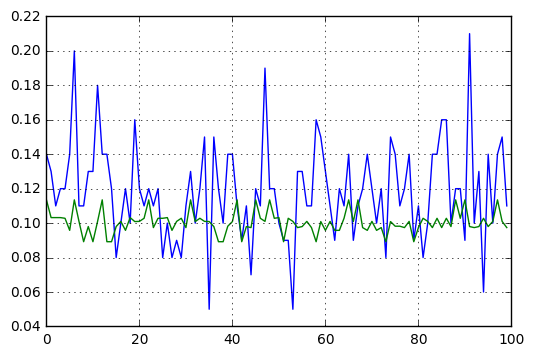

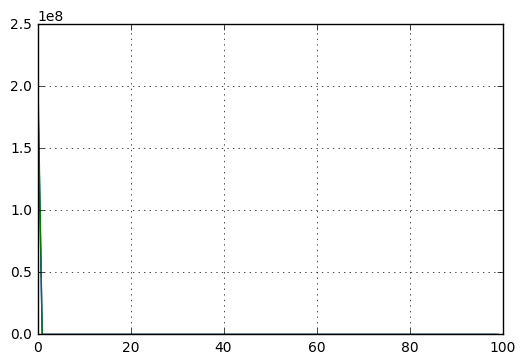

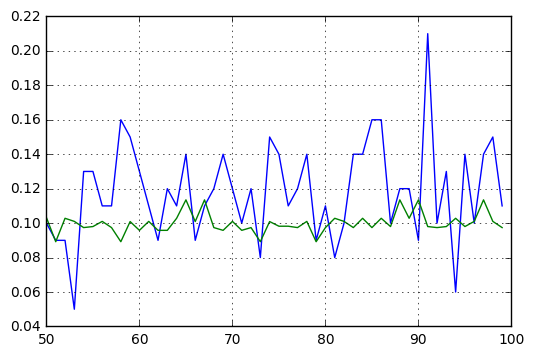

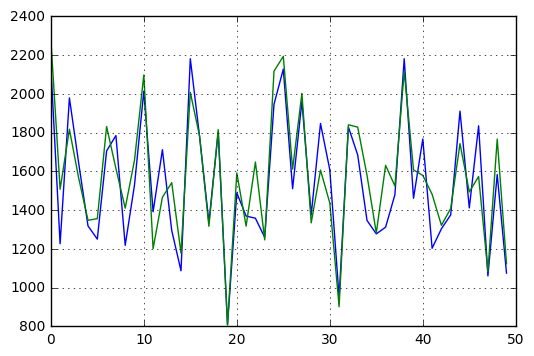

In [9]:
# 7. Plot and visualise the accuracy and loss

# accuracy training vs testing dataset
plt.plot(train_a)
plt.plot(test_a)
plt.grid(True)
plt.show()

# loss training vs testing dataset
plt.plot(train_c)
plt.plot(test_c)
plt.grid(True)
plt.show()

# Zoom in on the tail of the plots
zoom_point = 50
x_range = range(zoom_point,training_iter/epoch_size)
plt.plot(x_range, train_a[zoom_point:])
plt.plot(x_range, test_a[zoom_point:])
plt.grid(True)
plt.show()

plt.plot(train_c[zoom_point:])
plt.plot(test_c[zoom_point:])
plt.grid(True)
plt.show()

## Conv NN with Adam optimizer

In [10]:
# 1. Define Variables and Placeholders
#the first dimension (None) will index the images in the mini-batch
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
Y_ = tf.placeholder(tf.float32, [None, 10])

# Conv layers
W1 = tf.Variable(tf.truncated_normal([5, 5, 1, 4], stddev=0.1))
B1 = tf.Variable(tf.ones([4])/10)
W2 = tf.Variable(tf.truncated_normal([5, 5, 4, 8], stddev=0.1))
B2 = tf.Variable(tf.ones([8])/10)
W3 = tf.Variable(tf.truncated_normal([4, 4, 8, 12], stddev=0.1))
B3 = tf.Variable(tf.ones([12])/10)

# Densely connected layer
W4 = tf.Variable(tf.truncated_normal([7 * 7 * 12, 200], stddev=0.1))
B4 = tf.Variable(tf.ones([200])/10)

# Readout layer
W5 = tf.Variable(tf.truncated_normal([200, 10], stddev=0.1))
B5 = tf.Variable(tf.ones([10])/10)


# 2. Define the model
Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME') + B1)
Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, 2, 2, 1], padding='SAME') + B2)
Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, 2, 2, 1], padding='SAME') + B3)

YY = tf.reshape(Y3, shape=[-1, 7 * 7 * 12])                
                
Y4 = tf.nn.relu(tf.matmul(YY, W4) + B4)
Ylogits = tf.matmul(Y4, W5) + B5
Y = tf.nn.softmax(Ylogits)

# 3. Define the loss function  
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(Ylogits, Y_) # calculate cross-entropy with logits
cross_entropy = tf.reduce_mean(cross_entropy)*100

# 4. Define the accuracy 
correct_prediction = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 5. Define an optimizer
train_step = tf.train.AdamOptimizer(0.005).minimize(cross_entropy)

# initialize
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

def training_step(i, update_test_data, update_train_data):

    print "\r", i,
    ####### actual learning 
    # reading batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)
    
    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y})
    
    ####### evaluating model performance for printing purposes
    # evaluation used to later visualize how well you did at a particular time in the training
    train_a = []
    train_c = []
    test_a = []
    test_c = []
    if update_train_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={X: batch_X, Y_: batch_Y})
        train_a.append(a)
        train_c.append(c)

    if update_test_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={X: mnist.test.images, Y_: mnist.test.labels})
        test_a.append(a)
        test_c.append(c)

    
    return (train_a, train_c, test_a, test_c)

# 6. Train and test the model, store the accuracy and loss per iteration

train_a = []
train_c = []
test_a = []
test_c = []
    
training_iter = 10000
epoch_size = 100
for i in range(training_iter):
    test = False
    if i % epoch_size == 0:
        test = True
    a, c, ta, tc = training_step(i, test, test)
    train_a += a
    train_c += c
    test_a += ta
    test_c += tc

9999


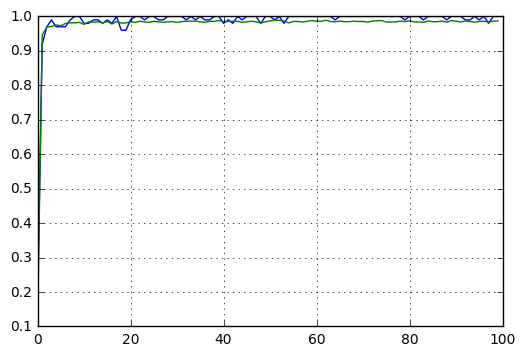

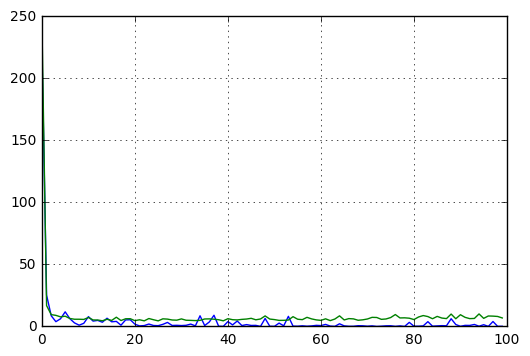

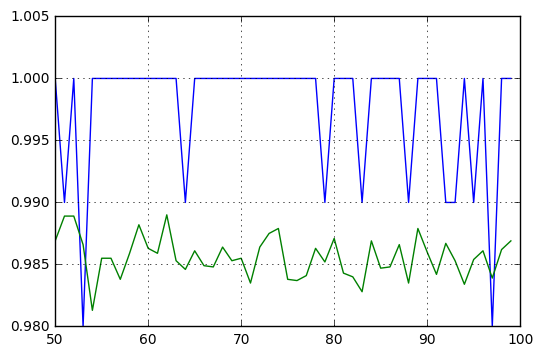

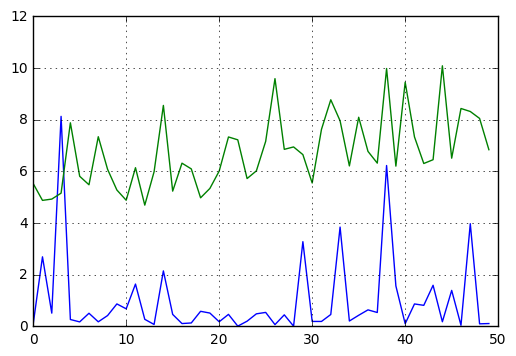

In [12]:
# 7. Plot and visualise the accuracy and loss

# accuracy training vs testing dataset
plt.plot(train_a)
plt.plot(test_a)
plt.grid(True)
plt.show()

# loss training vs testing dataset
plt.plot(train_c)
plt.plot(test_c)
plt.grid(True)
plt.show()

# Zoom in on the tail of the plots
zoom_point = 50
x_range = range(zoom_point,training_iter/epoch_size)
plt.plot(x_range, train_a[zoom_point:])
plt.plot(x_range, test_a[zoom_point:])
plt.grid(True)
plt.show()

plt.plot(train_c[zoom_point:])
plt.plot(test_c[zoom_point:])
plt.grid(True)
plt.show()

## Conv NN with Adam optimizer and learning decay

In [13]:
# 1. Define Variables and Placeholders
#the first dimension (None) will index the images in the mini-batch
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
Y_ = tf.placeholder(tf.float32, [None, 10])
lr = tf.placeholder(tf.float32)

# Conv layers
W1 = tf.Variable(tf.truncated_normal([5, 5, 1, 4], stddev=0.1))
B1 = tf.Variable(tf.ones([4])/10)
W2 = tf.Variable(tf.truncated_normal([5, 5, 4, 8], stddev=0.1))
B2 = tf.Variable(tf.ones([8])/10)
W3 = tf.Variable(tf.truncated_normal([4, 4, 8, 12], stddev=0.1))
B3 = tf.Variable(tf.ones([12])/10)

# Densely connected layer
W4 = tf.Variable(tf.truncated_normal([7 * 7 * 12, 200], stddev=0.1))
B4 = tf.Variable(tf.ones([200])/10)

# Readout layer
W5 = tf.Variable(tf.truncated_normal([200, 10], stddev=0.1))
B5 = tf.Variable(tf.ones([10])/10)


# 2. Define the model
Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME') + B1)
Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, 2, 2, 1], padding='SAME') + B2)
Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, 2, 2, 1], padding='SAME') + B3)

YY = tf.reshape(Y3, shape=[-1, 7 * 7 * 12])                
                
Y4 = tf.nn.relu(tf.matmul(YY, W4) + B4)
Ylogits = tf.matmul(Y4, W5) + B5
Y = tf.nn.softmax(Ylogits)

# 3. Define the loss function  
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(Ylogits, Y_) # calculate cross-entropy with logits
cross_entropy = tf.reduce_mean(cross_entropy)*100

# 4. Define the accuracy 
correct_prediction = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 5. Define an optimizer
train_step = tf.train.AdamOptimizer(0.005).minimize(cross_entropy)

# initialize
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

def training_step(i, update_test_data, update_train_data):

    print "\r", i,
    ####### actual learning 
    # reading batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)
    
    # Define learning rate
    min_learning = 0.0005
    max_learning = 0.005
    decay_speed = 1000.0
    learning_rate = min_learning + (max_learning - min_learning) * math.exp(-i/decay_speed)
    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y, lr: learning_rate})
    
    ####### evaluating model performance for printing purposes
    # evaluation used to later visualize how well you did at a particular time in the training
    train_a = []
    train_c = []
    test_a = []
    test_c = []
    if update_train_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={X: batch_X, Y_: batch_Y})
        train_a.append(a)
        train_c.append(c)

    if update_test_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={X: mnist.test.images, Y_: mnist.test.labels})
        test_a.append(a)
        test_c.append(c)

    
    return (train_a, train_c, test_a, test_c)

# 6. Train and test the model, store the accuracy and loss per iteration

train_a = []
train_c = []
test_a = []
test_c = []
    
training_iter = 10000
epoch_size = 100
for i in range(training_iter):
    test = False
    if i % epoch_size == 0:
        test = True
    a, c, ta, tc = training_step(i, test, test)
    train_a += a
    train_c += c
    test_a += ta
    test_c += tc

9999


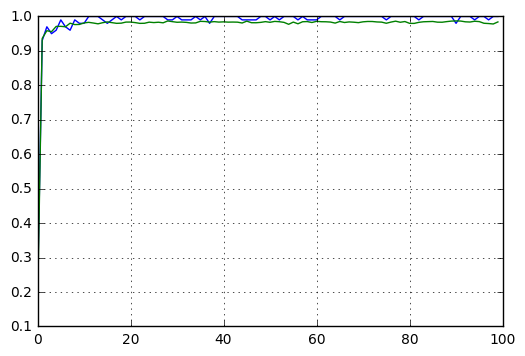

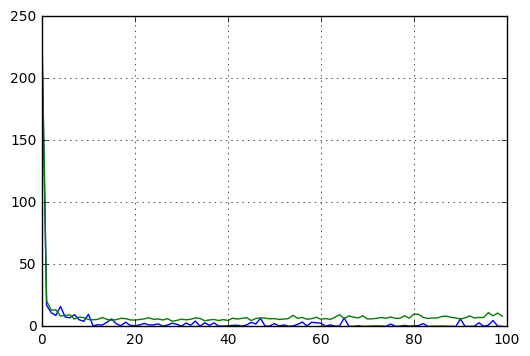

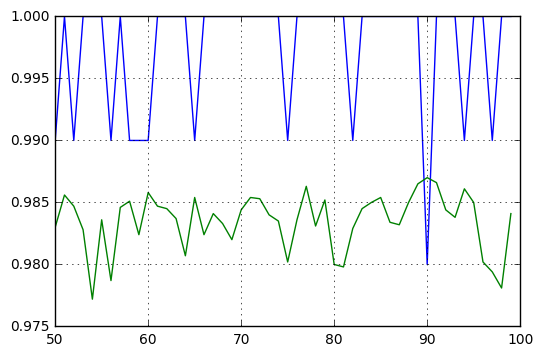

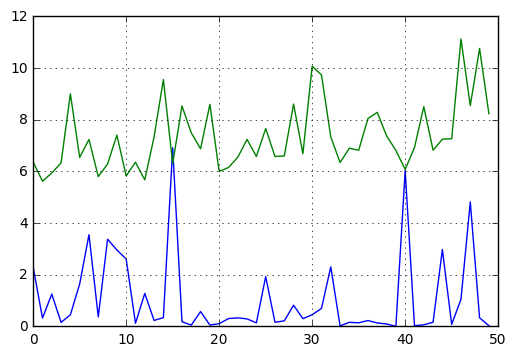

In [14]:
# 7. Plot and visualise the accuracy and loss

# accuracy training vs testing dataset
plt.plot(train_a)
plt.plot(test_a)
plt.grid(True)
plt.show()

# loss training vs testing dataset
plt.plot(train_c)
plt.plot(test_c)
plt.grid(True)
plt.show()

# Zoom in on the tail of the plots
zoom_point = 50
x_range = range(zoom_point,training_iter/epoch_size)
plt.plot(x_range, train_a[zoom_point:])
plt.plot(x_range, test_a[zoom_point:])
plt.grid(True)
plt.show()

plt.plot(train_c[zoom_point:])
plt.plot(test_c[zoom_point:])
plt.grid(True)
plt.show()

## Conv NN with Adam optimizer, learning decay, and dropout

In [16]:
# 1. Define Variables and Placeholders
#the first dimension (None) will index the images in the mini-batch
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
Y_ = tf.placeholder(tf.float32, [None, 10])
lr = tf.placeholder(tf.float32)
pkeep = tf.placeholder(tf.float32)

# Conv layers
W1 = tf.Variable(tf.truncated_normal([5, 5, 1, 4], stddev=0.1))
B1 = tf.Variable(tf.ones([4])/10)
W2 = tf.Variable(tf.truncated_normal([5, 5, 4, 8], stddev=0.1))
B2 = tf.Variable(tf.ones([8])/10)
W3 = tf.Variable(tf.truncated_normal([4, 4, 8, 12], stddev=0.1))
B3 = tf.Variable(tf.ones([12])/10)

# Densely connected layer
W4 = tf.Variable(tf.truncated_normal([7 * 7 * 12, 200], stddev=0.1))
B4 = tf.Variable(tf.ones([200])/10)

# Readout layer
W5 = tf.Variable(tf.truncated_normal([200, 10], stddev=0.1))
B5 = tf.Variable(tf.ones([10])/10)


# 2. Define the model
Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME') + B1)
Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, 2, 2, 1], padding='SAME') + B2)
Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, 2, 2, 1], padding='SAME') + B3)

YY = tf.reshape(Y3, shape=[-1, 7 * 7 * 12])                
                
Y4 = tf.nn.relu(tf.matmul(YY, W4) + B4)
YY4 = tf.nn.dropout(Y4, pkeep)
Ylogits = tf.matmul(YY4, W5) + B5
Y = tf.nn.softmax(Ylogits)

# 3. Define the loss function  
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(Ylogits, Y_) # calculate cross-entropy with logits
cross_entropy = tf.reduce_mean(cross_entropy)*100

# 4. Define the accuracy 
correct_prediction = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 5. Define an optimizer
train_step = tf.train.AdamOptimizer(0.005).minimize(cross_entropy)

# initialize
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

def training_step(i, update_test_data, update_train_data):

    print "\r", i,
    ####### actual learning 
    # reading batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)
    
    # Define learning rate
    min_learning = 0.0005
    max_learning = 0.005
    decay_speed = 1000.0
    learning_rate = min_learning + (max_learning - min_learning) * math.exp(-i/decay_speed)
    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y, lr: learning_rate, pkeep: 0.75})
    
    ####### evaluating model performance for printing purposes
    # evaluation used to later visualize how well you did at a particular time in the training
    train_a = []
    train_c = []
    test_a = []
    test_c = []
    if update_train_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={X: batch_X, Y_: batch_Y, pkeep: 1.0})
        train_a.append(a)
        train_c.append(c)

    if update_test_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={X: mnist.test.images, Y_: mnist.test.labels, pkeep: 1.0})
        test_a.append(a)
        test_c.append(c)

    
    return (train_a, train_c, test_a, test_c)

# 6. Train and test the model, store the accuracy and loss per iteration

train_a = []
train_c = []
test_a = []
test_c = []
    
training_iter = 10000
epoch_size = 100
for i in range(training_iter):
    test = False
    if i % epoch_size == 0:
        test = True
    a, c, ta, tc = training_step(i, test, test)
    train_a += a
    train_c += c
    test_a += ta
    test_c += tc

9999


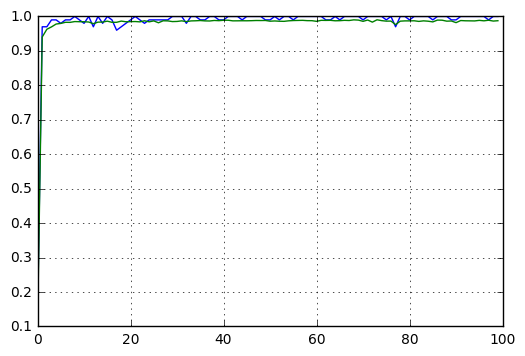

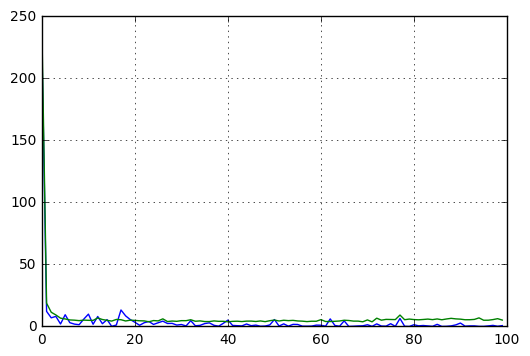

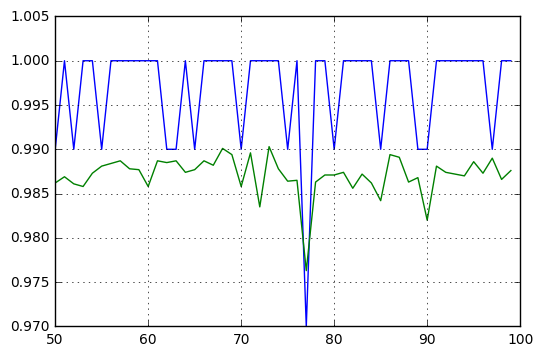

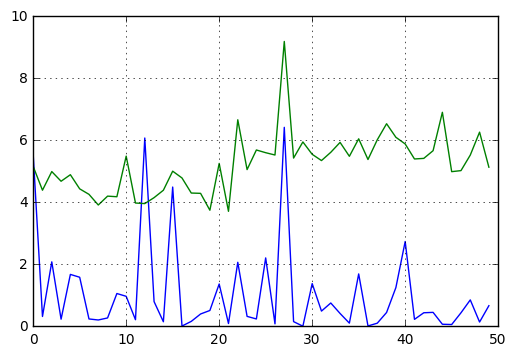

In [17]:
# 7. Plot and visualise the accuracy and loss

# accuracy training vs testing dataset
plt.plot(train_a)
plt.plot(test_a)
plt.grid(True)
plt.show()

# loss training vs testing dataset
plt.plot(train_c)
plt.plot(test_c)
plt.grid(True)
plt.show()

# Zoom in on the tail of the plots
zoom_point = 50
x_range = range(zoom_point,training_iter/epoch_size)
plt.plot(x_range, train_a[zoom_point:])
plt.plot(x_range, test_a[zoom_point:])
plt.grid(True)
plt.show()

plt.plot(train_c[zoom_point:])
plt.plot(test_c[zoom_point:])
plt.grid(True)
plt.show()